In [1]:
import pandas as pd
import jieba
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

pd.set_option('display.max_colwidth', None)#setting the maximize string show

fb = pd.read_csv('nysu_10902_2019立委_research.csv')
politics = pd.read_csv('9th_legislator_promise.csv')

In [4]:
kuan = fb[fb.page_name == "管碧玲 (kuanbiling)"]

# 依照按讚數 低到高排序
kuan = kuan.sort_values(by=['like_count'])
# 用新的排序當作順序
kuan.reset_index(inplace=True)

# 把時間格式轉換
kuan['new_date'] = pd.to_datetime(kuan['created_time_taipei']).dt.date
kuan['post_hour'] = pd.to_datetime(kuan['created_time_taipei']).dt.hour #找出發文 '時間'(hour)
kuan['month_year'] = pd.to_datetime(kuan['new_date']).dt.to_period('M')

kuan.head(1)

,index,post_id,page_id,page_name,page_category,message,story,type,permalink,created_time_gmt,...,haha_count,love_count,angry_count,sad_count,wow_count,comment_count,share_count,new_date,post_hour,month_year
0,11339,112542652141599_2941161235946379,112542652141599,管碧玲 (kuanbiling),政治人物,NaN,管碧玲 (kuanbiling) 更新了封面相片。,photo,https://www.facebook.com/112542652141599/posts/2941161235946379/,2020-01-06T07:18:54+0000,...,0,0,0,0,0,1,0,2020-01-06,15,2020-01


In [6]:
doc_names = range(len(kuan)) #有幾篇文章 : 528 篇文章
doc_names

range(0, 528)

結巴斷詞 jieba

len(liu): 看劉櫂豪的貼文總共有幾筆
list(liu['message']): 把要斷詞的內容轉成 list 格式
創造一個新的dataframe叫做liu_docs，型態是pandas.core.frame.DataFrame
原本liu_docs裡面的'jieba_results'欄位型態是pandas.core.series.Series，需要轉成'str'(字串)型態才能做後續處理。

In [8]:
import numpy as np
kuan = kuan.replace(np.nan, '', regex=True) #將nan取代成空白字串

text_list = list(kuan['message'])
# 把所有message轉成一個list 用for iterate

In [10]:
words = jieba.lcut(text_list[1], cut_all = False)
print(words)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\yangs\AppData\Local\Temp\jieba.cache
Loading model cost 0.671 seconds.
Prefix dict has been built successfully.


['願', '罹難', '的', '英雄', '們', '安息', '！', '\n', '您', '們', '正要', '傳送長', '官', '對', '辛苦', '弟兄', '的', '愛與', '期許', '，', '\n', '路途', '中', '，', '\n', '幻化', '為', '天使', '，', '\n', '永遠守護', '他們', '！', '\n', '引領', '與', '守護', '，', '\n', '變成', '一種', '永恆', '！']


In [11]:
words = jieba.lcut(text_list[527], cut_all = False)
print(words)

['公務員', '感動', '的', '見證', '：', '我們', '家', '不', '搞', '特權', '！', '\n', '\n', '我', '擔任', '立委', '14', '年', '，', '老公', '「', '無薪', '階級', '」', '11', '年', '。', '他', '不', '搞', '官位', '、', '不', '搞', '獨董', '、', '也', '不', '當民間', '企業', '的', '顧問', '；', '甚至', '去', '找個', '相關', '的', '職業', '工會', '補', '四年', '的', '勞保年資', '，', '都', '不願', '為', '。', '\n', '「', '君子', '慎獨', '」', '！', '在', '沒', '有人', '看', '得到', '的', '地方', '，', '我們', '家', '都', '自持', '甚嚴', '。', '\n', '女婿', '追', '隨指導', '教授', '擔任', '機要', '在', '先', '，', '娶', '我', '女兒', '在', '後', '，', '不是', '因為', '我', '的', '特權', '，', '我', '特別', '再', '說明', '一次', '。', '\n', '9', '/', '18', '媒體', '炒作', '女婿', '特權', '時', '，', '有', '一個', '勞保局', '的', '官員', '，', '9', '/', '19', '就', '在', '他', '參加', '的', '群', '組公開', '作見證', '，', '公務員', '看', '多', '了', '，', '他', '從', '老公', '勞保年', '金', '怎麼領', '，', '清楚', '看到', '這是', '一個', '不', '搞', '特權', '的', '家庭', '！', '\n', '他', '說', '老公', '的', '勞保年', '金比', '家庭', '主婦', '還少', '，', '他', '感動', '的', '為', '我', '不', '搞', '特權', '作見證', '。', '\n', '說', '我'

把要存斷詞結果的dataframe準備好之後，就可以開始斷詞了。</br>

第一個迴圈</br> 剛才我們知道，劉櫂豪的篇數有999篇： 我們可以用一個for迴圈來跑每一篇文章，i是對應文章的意思，會從1(第一篇)跑到999(第999篇)；</br> 而text_list就是我們剛剛轉成list型態的劉櫂豪貼文內容；text_list[1]，就是取出list第一個元素(第一篇貼文)的意思。</br>

第二個迴圈</br> words存的是文章斷詞後的集合物件(object)，我們需要跑第二個for迴圈把集合裡面的字取出來，</br> word代表斷詞集合中的一個字，先把字轉換成str(字串)型態之後，字和字之間加上空格存在一起。

append加回斷詞欄位</br> 之後把text內容存到'jieba_results'這個欄位裡面，再和liu_docs合併。</br> 最後我們liu_docs，只會一個欄位jieba_results，存斷詞之後的結果。

In [12]:
import jieba
from tqdm import tqdm
import re
jieba.load_userdict("dict.txt")
punctuation = " //，：:""()\n!！？｡＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘'‛“”„‟…‧﹏"""
re_punctuation = "[{}] ".format(punctuation)

# creat a df to store the jieba result
kuan_docs = pd.DataFrame(columns=['jieba_results']) # 建立df
kuan_docs['jieba_results'] = kuan_docs['jieba_results'].astype('str')

for i in doc_names: #從第一篇到最後一篇
    words = jieba.cut(text_list[i], cut_all = False)
    text = ''
    for word in words:
        text = text + ' ' + str(word) 
    #print(words)
    #print(i) #第幾篇文章
    #print(text) #第幾篇文章的斷詞結果
    text = re.sub(re_punctuation, "", text) # 把上面那些符號從text中刪掉
    text = re.sub(r'[0-9]','',text) # 刪掉數字
    text = re.sub(r'[a-zA-Z]','',text) #刪掉英文字
#刪除文字 更多標點符號
    text = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗🎉⏰💪]','',text)  # 注意裡面不能有空白！
    s = pd.Series({'jieba_results': text})
    kuan_docs = kuan_docs.append(s, ignore_index=True)#每次的斷詞結果都加回liu_docs

In [13]:
kuan['jieba_results'] = kuan_docs
kuan_post = kuan[['new_date','message','jieba_results','like_count']]
kuan_post

,new_date,message,jieba_results,like_count
0,2020-01-06,,,13
1,2020-01-02,願罹難的英雄們安息！\n您們正要傳送長官對辛苦弟兄的愛與期許，\n路途中，\n幻化為天使，\n永遠守護他們！\n引領與守護，\n變成一種永恆！,願 罹難 的 英雄 們 安息 您 們 正要 傳送 長官 對 辛苦 弟兄 的 愛與 期許 路途 中 幻化 為 天使 永遠守護 他們 引領 與 守護 變成 一種 永恆,14
2,2019-02-28,,,50
3,2019-05-03,母親節話家常，聊得很快樂\n\nhttps://www.facebook.com/1770605486509984/videos/441773279910666/,母親節 話家常 聊得 很快 樂 /,66
4,2019-01-18,「開放政府，行動內閣」，我們這樣做，人民會瞭解我們，支持我們！\nhttps://www.facebook.com/gogogoeball/videos/410991816307519/,開放 政府 行動 內閣 我們 這樣 做 人民 會 瞭解 我們 支持 我們 /,94
...,...,...,...,...
523,2019-11-19,難道侯友宜是韓國瑜的剋星？\n\n這是10/22眾多媒體的報導：\n\n「～～侯友宜表示，新北今年的目標已經達標，但達標不是一個目的，最近台商回來蠻多，新北已服務39家回流台商，預估投資金額超過3800億元，已落實超過1000億元，創造超過1萬8千個就業機會。～～～」,難道 侯友宜 是 韓國瑜 的 剋星 這是 眾多 媒體 的 報導 侯友宜 表示 新北 今年 的 目標 已 經達標 但達標 不是 一個 目的 最近 台商 回來 蠻 多 新北 已 服務 家 回流 台商 預估 投資金額 超過 億元 已落 實超過 億元 創造 超過 萬 千個 就業機會 」,6730
524,2019-12-30,非常非常努力的捍衛「反滲透法」，好不容易討論完條文，多麼害怕明天的議程又會節外生枝！\n結果，因為時代力量要求變更議程，要把「礦業法」放進來，一時，出現議程因此被操作的危機，對於明天能不能順利進行表決大戰，出現危機。\n我和周春米委員，只好預防性的開始排隊！\n\n最後，因為協商結論反對黨都沒有簽字，我們為了以防萬一，只好在議場排隊備戰。\n\n再更新：我們最後願意相信院長協商時的裁示會被尊重，因此我們撤離議場的排隊！,非常 非常 努力 的 捍衛 反滲透法 好不容易 討論 完條文 多麼 害怕 明天 的 議程 又 會 節外 生枝 結果 因為 時代 力量 要求 變 更 議程 要 把 礦業法 放進 來 一時 出現 議程 因此 被 操作 的 危機 對 於 明天 能 不能 順利 進行表 決大戰 出現 危機 我 和 周春米 委員 只好 預防性 的 開始 排隊 最 後 因為 協商 結論 反 對 黨 都 沒 有 簽字 我們 為 了 以防 萬一 只好 在 議場 排隊 備戰 再 更新 我們 最後願意 相信 院長 協商時 的 裁示 會 被 尊重 因此 我們 撤離 議場 的 排隊,6876
525,2019-12-21,2:55分了，第九大隊才剛剛開始出發！\n第一大隊已經經過中央公園！\n光復高雄，氣勢驚人！\nWecare主辦單位粗估遊行人數已達30萬。,分 了 第九 大隊 才 剛剛 開始 出發 第一 大隊 已經 經過 中央公園 光復高雄 氣勢 驚人 主辦 單位 粗估 遊 行人 數已 達 萬,7455
526,2019-11-16,人山人海，\n2.1萬人在線上，\n我們的熱情，\n預告光復高雄！,人山人海 萬人 在 線上 我們 的 熱情 預告 光復高雄,8008


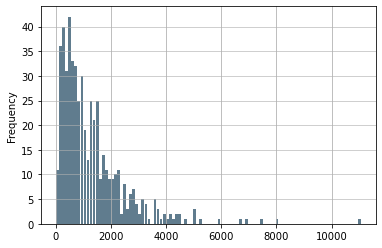

In [14]:
commutes = kuan_post['like_count']
commutes.plot.hist(grid=True, bins=100, rwidth=0.9,
color='#607c8e')
plt.grid(axis='y', alpha=0.75)

In [15]:
temp = kuan_post[(kuan_post['like_count'] <= 6000) & (kuan_post['like_count'] > 500)]
temp

,new_date,message,jieba_results,like_count
135,2020-01-01,新年快樂！,新年 快樂,502
136,2019-05-24,我尊敬的朋友：中山大學社會系主任，王宏仁教授今天早上與市府官員的另一半，登記結婚了。\n我祝福他們幸福美滿，特別高興，恭喜他們！\n\n20190517 Speech of DPP Kuanbiling@Congress regarding same-sex marriage bill\nhttps://youtu.be/Ybk1-lC8ttE,我 尊敬 的 朋友 中山大學 社會 系主任 王 宏仁 教授 今天 早上 與 市府 官員 的 另一半 登記 結婚 了 我 祝福 他們 幸福 美滿 特別 高興 恭喜 他們 @,503
137,2019-09-11,明天晚上要和昆澤委員合唱什麼歌呢？\n正在躊謀～～～\n\n對了，\n歡迎大家相招來𨑨迌ㄋㄟ\n～～～～,明天 晚上 要 和 昆澤 委員 合唱 什麼 歌 呢 正在 躊謀 對 了 歡迎 大家 相招來 𨑨 迌 ㄋ ㄟ ～,506
138,2019-04-16,,,508
139,2019-05-08,聲援簡煥宗議員！\n所有正義的力量，應該團結對抗霸權！,聲援 簡煥宗議員 所有 正義的 力量 應該 團結 對 抗霸權,508
...,...,...,...,...
518,2019-07-13,有沒有看到納斯達克主席Michael R. Splinter笑得多開懷？！\n\n小英總統在今天的高峰會上，數度引起全場大笑，她的幽默很有深意，照片中Splinter 的笑容笑得多麽淋漓盡致！\n\n他笑，是因為小英說了一句：\n台灣ICT產品應該比中國的可靠安全！\n\n你知道為什麼全場大笑了吧！\n\n小英總統可以親自向眾多企業領袖介紹台灣，可以在國際場合創造友善的氣氛，實在令人驕傲！\n\n節錄ㄧ段總統介紹台灣的內容分享給大家：\n\n「⋯⋯ 台灣的經商環境自由，凸顯我們與區域鄰國的不同，也將我們與美國緊密連結在一起。我們的法治扎實，保護智慧財產權很徹底，而且法規環境也很友善。過去三年多來，我的團隊不斷鬆綁不必要的法規拘束，可以更方便容易在台灣徵才、經商和擴大營運。\n \n今年，傳統基金會將台灣列為亞洲最佳經商地點之一，台灣的經濟自由度也名列世界第十⋯⋯」,有 沒 有 看到 納斯達克 主席 笑 得 多 開懷 小英總統 在 今天 的 高峰 會上 數度 引起 全場 大笑 她 的 幽默 很 有 深意 照片 中 的 笑容 笑 得 多 麽 淋漓 盡致 他 笑 是 因為 小英 說 了 一句 台灣 產品 應該 比 中國 的 可靠 安全 你 知道 為 什麼 全場 大笑 了 吧 小英總統 可以 親自向 眾多 企業 領袖 介紹 台灣 可以 在 國際場 合 創造 友善 的 氣氛 實在 令人 驕傲 節錄 ㄧ 段 總統 介紹 台灣 的 內容 分享 給 大家 台灣 的 經商 環境 自由 凸顯 我們 與 區域 鄰國 的 不同 也將 我們 與 美國 緊密 連結 在 一起 我們 的 法治 扎實 保護 智慧 財產權 很 徹底 而且 法規 環境 也 很 友善 過去 三年 多來 我 的 團隊 不 斷 鬆 綁 不必要 的 法規 拘束 可以 更 方便 容易 在 台灣 徵才 經商 和 擴大營運 今年 傳統 基金 會將 台灣 列為 亞洲 最佳 經商 地點 之一 台灣 的 經濟 自由度 也 名列 世界 第十 」,4996
519,2019-08-10,小英來到鹽埕區的文武聖殿，\n支持者強強滾！\n真的是強強滾ㄧㄝ～～,小英來 到 鹽埕 區的 文武 聖殿 支持者 強強 滾 真的 是 強強 滾 ㄧ ㄝ ～,5005
520,2019-08-18,30年，\n歲月不留人～～～,年 歲 月 不留 人 ～,5078
521,2019-08-17,邁邁哥的再一次週末—-還是勘災\n\n高雄的雨災，造成六龜的土石流，野溪水流湍急，卻被土石流淹沒，溪水溢流，夾帶土石，把蓮霧田的果樹、農業設施毀損無數。\n\n看到溪邊堆積如山的土石，就是連夜清理，讓水流通暢，降低災損的結果。\n\n土石之多，實在驚人。\n\n這些，在邱議瑩委員與區長、交通部次長、水保局長⋯⋯等的陪同說明下，邁邁哥都看到了，\n他當場做了重要的指示：\n\n區公所第一時間啟動清理命令的申請程序，要縮短到事前授權、即時啟動、事後報備；立即統計農損規模、農業設施的補助要專案列入考慮⋯⋯⋯\n\n精準！這個確實精準！\n\n邁邁哥的周末⋯⋯再度勘災！,邁邁哥 的 再 一次 週末 還是 勘災 高雄 的 雨災 造成 六龜 的 土石 流 野 溪水 流 湍急 卻 被 土石 流淹 沒 溪水 溢流 夾帶 土石 把 蓮霧 田 的 果樹 農業 設施毀 損無數 看到 溪邊 堆積 如山 的 土石 就是 連夜 清理 讓 水 流通 暢 降低 災損 的 結果 土石 之多 實在 驚人 這些 在 邱議瑩 委員 與 區長 交通部 次長 水保局 長 等 的 陪同 說 明下 邁邁哥 都 看到 了 他 當場 做 了 重要 的 指示 區 公所 第一 時間 啟動 清理 命令 的 申請 程序 要縮 短到 事前 授權 即時 啟動 事後報備 立即 統計 農損 規模 農業 設施 的 補助 要 專案 列入 考慮 精準 這個 確實 精準 邁邁哥 的 周末 再度 勘災,5237


In [16]:
corpus = temp['jieba_results'].values.tolist()

In [17]:
# TF-IDF
# coding:utf-8  

#算字頻
from sklearn.feature_extraction.text import CountVectorizer  
vectorizer = CountVectorizer()  # 計算單字出現在文件中的次數
X = vectorizer.fit_transform(corpus) #  input must be a list, return a matrix (#of corpus) x (# of word) # 201 x 4835
word = vectorizer.get_feature_names() # column name which is the word
message_column = word

#計算TFIDF
from sklearn.feature_extraction.text import TfidfTransformer  # 計算tfidf
transformer = TfidfTransformer()  
tfidf = transformer.fit_transform(X) # X : corpus x word matrix, output:201 x 4835

In [18]:
tfidf_view = pd.DataFrame(tfidf.toarray(), columns = vectorizer.get_feature_names())
tfidf_view

,一一,一下,一世,一中,一事,一些,一人,一付,一代,一件,...,鼓舞,鼓舞人心,鼠膽,鼻子走,齊發,齷齪,龍頭,龐大,龔薩福,龔薩福閣
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# #使用LDA演算法
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=8, random_state=None)
LDA.fit(X) # 用countrvectorizer() result 去fit 

topic_message = list()
#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    mes_topic = [vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(mes_topic)
    for i in mes_topic:
        topic_message.append(i)

TOP 10 WORDS PER TOPIC #0
['小英', '就是', '可以', '這個', '人民', '沼田', '一個', '中國', '我們', '台灣']
TOP 10 WORDS PER TOPIC #1
['選舉', '一個', '今天', '這個', '香港', '司法', '中國', '他們', '台灣', '我們']
TOP 10 WORDS PER TOPIC #2
['因為', '總統', '可以', '政治', '就是', '國家', '中國', '香港', '台灣', '我們']
TOP 10 WORDS PER TOPIC #3
['因為', '這樣', '高雄', '美國', '可以', '總統', '我們', '一個', '人民', '台灣']
TOP 10 WORDS PER TOPIC #4
['人民', '不是', '這種', '小英', '可以', '國民黨', '我們', '政治', '一個', '台灣']
TOP 10 WORDS PER TOPIC #5
['政府', '當時', '如何', '社會', '大家', '蘇啟', '中國', '網路', '我們', '台灣']
TOP 10 WORDS PER TOPIC #6
['王立強', '政治', '人民', '立法院', '香港', '國民黨', '職權', '台灣', '我們', '委員']
TOP 10 WORDS PER TOPIC #7
['這個', '不是', '今天', '我們', '考績', '韓國瑜', '觀光', '總統', '外交官', '台灣']


In [20]:
LDA.fit(tfidf) # 用tfidf result 去fit 

#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])

TOP 10 WORDS PER TOPIC #0
['職權', '素人', '快來', '國民黨', '一直', '張善政', '委員', '中秋', '開心', '台灣']
TOP 10 WORDS PER TOPIC #1
['這是', '高雄', '司法', '總統', '這個', '人民', '中國', '香港', '我們', '台灣']
TOP 10 WORDS PER TOPIC #2
['助理', '加油', '這個', '一起', '團隊', '祈禱', '國家', '蘇院長', '台灣', '我們']
TOP 10 WORDS PER TOPIC #3
['香港', '力量', '一個', '這樣', '總統', '他們', '高雄', '台灣', '加油', '我們']
TOP 10 WORDS PER TOPIC #4
['不留', '哀傷', '就是', '人民', '我們', '他們', '可以', '總統', '高雄', '台灣']
TOP 10 WORDS PER TOPIC #5
['人民', '國民黨', '真的', '中國', '知道', '一個', '可以', '我們', '厲害', '香港']
TOP 10 WORDS PER TOPIC #6
['唬爛', '外交', '政治', '大家', '恐怖', '初選', '委員', '台灣', '看到', '韓國瑜']
TOP 10 WORDS PER TOPIC #7
['政治', '韓國瑜', '總統', '立委', '選舉', '今天', '大家', '我們', '中國', '台灣']


In [21]:
#政見做斷詞

politics_kuan = politics[politics.姓名 == "管 碧 玲"].政見.to_string()
#politics_kuan = politics[politics.姓名 == "吳思瑤"].政見.to_string()

politics_kuan = re.sub(re_punctuation, "", politics_kuan)
politics_kuan = re.sub(r'[0-9]','',politics_kuan)
politics_kuan = re.sub(r'[a-zA-Z]','',politics_kuan)
politics_kuan = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗、，」「（）]','',politics_kuan)  # 注意裡面不能有空白！
jieba.load_userdict("dict.txt")
politics_words = jieba.lcut(politics_kuan, cut_all = False)

In [23]:
#觀察政見的斷詞結果
inspect_words = jieba.cut(politics_kuan, cut_all = False)
text = ''
for word in inspect_words:
    text = text + ' ' + str(word) 
text = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗+]','',text)
text = re.sub(re_punctuation, "", text)
text

' 一 扭轉 產業 重北輕南 之 偏失 強化 投資 高雄 增進 高雄 子弟 就業 二 推動 國會 改革 並堅持 台灣 與 中國 簽訂 雙邊協議 之 透明 及國會 監督 三 持續 監督 政府 落實 國際 參與 強化 台灣 之 地位 捍衛 國家 主權 與 尊嚴 四 建立 有效 法律 體系 把 關食材 食品 衛生 安全 維護 人民 食安 基本 權益 五促 進網 路通 訊 環境 保護 網路個 人 資料 隱私 安全 促進 政府 資訊 透明 六 健全 社會住宅 機制 及 幼托 教育系 統使 年輕人 無後顧 之 憂 七反 對 高雄捷運 採 要求 中央 負擔 經費 全面 佈 建 輕軌 捷運 快速道路 健全 高雄 交通 路網 八 衛武營流行音樂中心 時代來 臨強化 在 地 文化 產業 扶植 高雄 藝文 專業 人才 九 持續 推動 文化 資產 保護及 國家 與 地方 鐵道 博物 館 文化 園區 體系 十由 政府 投資 推動 鹽埕 旗津 及 哈瑪星 街廓 再造 繁榮 地方 十一 爭取 落實 旗津 醫院 小時 急診 專案 解決 旗津 港埠 用地 爭議 暫停 所有 訴訟 程序 十二 加強 海洋 觀光 投資 規劃 旗津 第二 聯外 道路 解決 貨櫃車 與 民眾 爭道 問題 十三 充實 鼓山 大樓區 教育 文化 運動 設施 及 幼兒 活動 遊憩 空間 十四 協助 高雄 鐵路地下化 後 城市 廊道 之綠化 與 商業 振興並 堅持 土地 無償 撥用 十五 維護及 扶植 傳統市場 與 傳統 民生 商業 店家 的 生存 發展 十六 強化 母語教育 推動 國家 語言 發展法 建立 國家 語言 資料 庫 公共 場應 提供 母語 服務 十七 推展 高雄 客家 文化 保存 與 生態 產業 群落 創造 客家 子弟 就業機會 十八 檢討 公寓 大廈 管理 條例 由 政府 提供 培訓 計畫 全面 提升 公寓 大廈 管委 會 法治 與 財務 管理 能力'

In [24]:
# 政見做tfidf
p_vectorizer = CountVectorizer()  
p_X = p_vectorizer.fit_transform(politics_words)  
p_colword = p_vectorizer.get_feature_names() 
p_transformer = TfidfTransformer()  
p_tfidf = p_transformer.fit_transform(p_X) #143 word in 

p_LDA = LatentDirichletAllocation(n_components=8, random_state=None)

# 政見做LDA
p_LDA.fit(p_tfidf)
topic_politics = list()
#觀看結果
for i,topic in enumerate(p_LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    topic_p = [p_vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(topic_p)
    for i in topic_p:
        topic_politics.append(i)

TOP 10 WORDS PER TOPIC #0
['充實', '問題', '國際', '母語教育', '輕軌', '保存', '解決', '子弟', '資料', '推動']
TOP 10 WORDS PER TOPIC #1
['訴訟', '空間', '關食材', '城市', '建立', '商業', '語言', '台灣', '投資', '旗津']
TOP 10 WORDS PER TOPIC #2
['用地', '鐵道', '經費', '捷運', '所有', '增進', '人民', '醫院', '體系', '大廈']
TOP 10 WORDS PER TOPIC #3
['路通', '路網', '隱私', '觀光', '鼓山', '管理', '監督', '全面', '產業', '國家']
TOP 10 WORDS PER TOPIC #4
['鐵路地下化', '爭取', '條例', '就業', '海洋', '扭轉', '哈瑪星', '專業', '落實', '地方']
TOP 10 WORDS PER TOPIC #5
['五促', '群落', '港埠', '大樓區', '無償', '傳統', '公寓', '安全', '文化', '高雄']
TOP 10 WORDS PER TOPIC #6
['進網', '資產', '參與', '活動', '提供', '扶植', '客家', '健全', '強化', '政府']
TOP 10 WORDS PER TOPIC #7
['堅持', '並堅持', '專案', '網路個', '公共', '衛武營流行音樂中心', '幼托', '創造', '透明', '持續']


In [25]:
# #政見所有topic 總表
for i in topic_politics:
#for i in topic_:# 文章內容的topic所有字的總表
    print(i,end = ', ')

充實, 問題, 國際, 母語教育, 輕軌, 保存, 解決, 子弟, 資料, 推動, 訴訟, 空間, 關食材, 城市, 建立, 商業, 語言, 台灣, 投資, 旗津, 用地, 鐵道, 經費, 捷運, 所有, 增進, 人民, 醫院, 體系, 大廈, 路通, 路網, 隱私, 觀光, 鼓山, 管理, 監督, 全面, 產業, 國家, 鐵路地下化, 爭取, 條例, 就業, 海洋, 扭轉, 哈瑪星, 專業, 落實, 地方, 五促, 群落, 港埠, 大樓區, 無償, 傳統, 公寓, 安全, 文化, 高雄, 進網, 資產, 參與, 活動, 提供, 扶植, 客家, 健全, 強化, 政府, 堅持, 並堅持, 專案, 網路個, 公共, 衛武營流行音樂中心, 幼托, 創造, 透明, 持續, 

In [26]:
#在LDA結果中每個Topic政見的詞 、 臉書貼文的詞的交集 
#set(topic_politics).intersection(topic_message) 
Counter(topic_politics+topic_message) #綜合臉書發文、政見 Topic 的詞 看出現次數
#台灣 人民 我們 

Counter({'充實': 1,
         '問題': 1,
         '國際': 1,
         '母語教育': 1,
         '輕軌': 1,
         '保存': 1,
         '解決': 1,
         '子弟': 1,
         '資料': 1,
         '推動': 1,
         '訴訟': 1,
         '空間': 1,
         '關食材': 1,
         '城市': 1,
         '建立': 1,
         '商業': 1,
         '語言': 1,
         '台灣': 9,
         '投資': 1,
         '旗津': 1,
         '用地': 1,
         '鐵道': 1,
         '經費': 1,
         '捷運': 1,
         '所有': 1,
         '增進': 1,
         '人民': 5,
         '醫院': 1,
         '體系': 1,
         '大廈': 1,
         '路通': 1,
         '路網': 1,
         '隱私': 1,
         '觀光': 2,
         '鼓山': 1,
         '管理': 1,
         '監督': 1,
         '全面': 1,
         '產業': 1,
         '國家': 2,
         '鐵路地下化': 1,
         '爭取': 1,
         '條例': 1,
         '就業': 1,
         '海洋': 1,
         '扭轉': 1,
         '哈瑪星': 1,
         '專業': 1,
         '落實': 1,
         '地方': 1,
         '五促': 1,
         '群落': 1,
         '港埠': 1,
         '大樓區': 1,
         '無償': 1,
  

In [27]:
top_10_message = tfidf_view.sort_values(by = ['台灣'], ascending = False).index[:10] 
# 把台灣tfidf 高的文章做排序取top 10的文章 拿出文章的index
tfidf_view.sort_values(by = ['台灣'], ascending = False).head(10)

,一一,一下,一世,一中,一事,一些,一人,一付,一代,一件,...,鼓舞,鼓舞人心,鼠膽,鼻子走,齊發,齷齪,龍頭,龐大,龔薩福,龔薩福閣
127,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.038476,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
383,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161,0.0,0.0,0.0,0.0,0.0,0.000000,0.04695,0.0,0.0,0.0,...,0.0,0.04695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[127,]).sort_values(by = 127, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption

,127
台灣,0.558529
孤立,0.234311
處心,0.219160
積慮,0.219160
分化,0.219160
...,...
小三通,0.000000
導致波,0.000000
導致,0.000000
導演,0.000000


In [29]:
#這些都是讚數很高的文章 每篇文章最高的tfidf 詞
message_newtfidf = tfidf_view
message_newtfidf['term'] = message_newtfidf[message_column].idxmax(axis = 1)
message_newtfidf['term'].tail(20) # 在這邊的話看讚數最多的文章他們tfidf 最高的詞是什麼

368     今天
369     覺醒
370     沙包
371     平安
372    假新聞
373     華航
374     九月
375     企業
376     台語
377     主席
378     收到
379    大仁哥
380    停車位
381     加油
382     生日
383     經商
384     強強
385     不留
386     土石
387     攝影
Name: term, dtype: object

In [30]:
#假如以剛剛科學園區相關主題為例 想看tfidf 最高的詞是兩岸關係的文章
message_newtfidf[message_newtfidf['term']=="中國"]

,一一,一下,一世,一中,一事,一些,一人,一付,一代,一件,...,鼓舞人心,鼠膽,鼻子走,齊發,齷齪,龍頭,龐大,龔薩福,龔薩福閣,term
161,0.0,0.0,0.0,0.0,0.0,0.0,0.04695,0.0,0.0,0.0,...,0.04695,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,中國
203,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.084276,0.0,0.0,0.0,0.0,0.0,中國
244,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,中國
270,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,中國


In [32]:
# 會發現文章出現tfidf是產業的很少，很正常 因為出現太多反而tfidf不會高！
temp.iloc[127,]

new_date                                                                                                                        2019-08-06
message                 中國最怕台灣人意志堅定！\n\n模糊台灣歷史的；\n分化台灣政治的；\n綁架台灣經濟的；\n孤立台灣外交的；\n利誘台灣民心的；\n威嚇台灣安全的；\n⋯⋯⋯⋯⋯\n⋯⋯⋯⋯⋯\n\n還有什麼嗎？\n以上這些，處心積慮，都做了！
jieba_results     中國 最 怕 台灣 人 意志 堅定 模糊 台灣 歷史 的 分化 台灣 政治 的 綁架 台灣 經濟 的 孤立 台灣 外交 的 利誘 台灣 民心 的 威嚇 台灣 安全 的           還有 什麼 嗎 以上 這些 處心 積慮 都 做 了 
like_count                                                                                                                             948
Name: 262, dtype: object

In [51]:
words = jieba.lcut(text_list[1], cut_all = False)
print(words)

['蘇院長', '這個', '真是', '厲害', '，', '真是', '好文', '！', '\n', '\n', 'https', ':', '/', '/', 'www', '.', 'facebook', '.', 'com', '/', '45289011269', '/', 'posts', '/', '10156136024671270', '/']


In [33]:
# LDA : 看每篇文章被分配在哪些主題  (tfidf)
#review topic 結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])

TOP 10 WORDS PER TOPIC #0
['職權', '素人', '快來', '國民黨', '一直', '張善政', '委員', '中秋', '開心', '台灣']
TOP 10 WORDS PER TOPIC #1
['這是', '高雄', '司法', '總統', '這個', '人民', '中國', '香港', '我們', '台灣']
TOP 10 WORDS PER TOPIC #2
['助理', '加油', '這個', '一起', '團隊', '祈禱', '國家', '蘇院長', '台灣', '我們']
TOP 10 WORDS PER TOPIC #3
['香港', '力量', '一個', '這樣', '總統', '他們', '高雄', '台灣', '加油', '我們']
TOP 10 WORDS PER TOPIC #4
['不留', '哀傷', '就是', '人民', '我們', '他們', '可以', '總統', '高雄', '台灣']
TOP 10 WORDS PER TOPIC #5
['人民', '國民黨', '真的', '中國', '知道', '一個', '可以', '我們', '厲害', '香港']
TOP 10 WORDS PER TOPIC #6
['唬爛', '外交', '政治', '大家', '恐怖', '初選', '委員', '台灣', '看到', '韓國瑜']
TOP 10 WORDS PER TOPIC #7
['政治', '韓國瑜', '總統', '立委', '選舉', '今天', '大家', '我們', '中國', '台灣']


In [34]:
#可以猜猜看第一篇文是哪個topic 
temp.iloc[:,[0,2]]

,new_date,jieba_results
135,2020-01-01,新年 快樂
136,2019-05-24,我 尊敬 的 朋友 中山大學 社會 系主任 王 宏仁 教授 今天 早上 與 市府 官員 的 另一半 登記 結婚 了 我 祝福 他們 幸福 美滿 特別 高興 恭喜 他們 @
137,2019-09-11,明天 晚上 要 和 昆澤 委員 合唱 什麼 歌 呢 正在 躊謀 對 了 歡迎 大家 相招來 𨑨 迌 ㄋ ㄟ ～
138,2019-04-16,
139,2019-05-08,聲援 簡煥宗議員 所有 正義的 力量 應該 團結 對 抗霸權
...,...,...
518,2019-07-13,有 沒 有 看到 納斯達克 主席 笑 得 多 開懷 小英總統 在 今天 的 高峰 會上 數度 引起 全場 大笑 她 的 幽默 很 有 深意 照片 中 的 笑容 笑 得 多 麽 淋漓 盡致 他 笑 是 因為 小英 說 了 一句 台灣 產品 應該 比 中國 的 可靠 安全 你 知道 為 什麼 全場 大笑 了 吧 小英總統 可以 親自向 眾多 企業 領袖 介紹 台灣 可以 在 國際場 合 創造 友善 的 氣氛 實在 令人 驕傲 節錄 ㄧ 段 總統 介紹 台灣 的 內容 分享 給 大家 台灣 的 經商 環境 自由 凸顯 我們 與 區域 鄰國 的 不同 也將 我們 與 美國 緊密 連結 在 一起 我們 的 法治 扎實 保護 智慧 財產權 很 徹底 而且 法規 環境 也 很 友善 過去 三年 多來 我 的 團隊 不 斷 鬆 綁 不必要 的 法規 拘束 可以 更 方便 容易 在 台灣 徵才 經商 和 擴大營運 今年 傳統 基金 會將 台灣 列為 亞洲 最佳 經商 地點 之一 台灣 的 經濟 自由度 也 名列 世界 第十 」
519,2019-08-10,小英來 到 鹽埕 區的 文武 聖殿 支持者 強強 滾 真的 是 強強 滾 ㄧ ㄝ ～
520,2019-08-18,年 歲 月 不留 人 ～
521,2019-08-17,邁邁哥 的 再 一次 週末 還是 勘災 高雄 的 雨災 造成 六龜 的 土石 流 野 溪水 流 湍急 卻 被 土石 流淹 沒 溪水 溢流 夾帶 土石 把 蓮霧 田 的 果樹 農業 設施毀 損無數 看到 溪邊 堆積 如山 的 土石 就是 連夜 清理 讓 水 流通 暢 降低 災損 的 結果 土石 之多 實在 驚人 這些 在 邱議瑩 委員 與 區長 交通部 次長 水保局 長 等 的 陪同 說 明下 邁邁哥 都 看到 了 他 當場 做 了 重要 的 指示 區 公所 第一 時間 啟動 清理 命令 的 申請 程序 要縮 短到 事前 授權 即時 啟動 事後報備 立即 統計 農損 規模 農業 設施 的 補助 要 專案 列入 考慮 精準 這個 確實 精準 邁邁哥 的 周末 再度 勘災


In [35]:
#LDA classification 
temp["topic"]=""#add new column 

doc_topic = LDA.transform(tfidf)
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()

    temp.iloc[n,4] = topic_most_pr
temp

<ipython-input-35-3dbfd841bfcf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["topic"]=""#add new column
C:\Users\yangs\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,new_date,message,jieba_results,like_count,topic
135,2020-01-01,新年快樂！,新年 快樂,502,1
136,2019-05-24,我尊敬的朋友：中山大學社會系主任，王宏仁教授今天早上與市府官員的另一半，登記結婚了。\n我祝福他們幸福美滿，特別高興，恭喜他們！\n\n20190517 Speech of DPP Kuanbiling@Congress regarding same-sex marriage bill\nhttps://youtu.be/Ybk1-lC8ttE,我 尊敬 的 朋友 中山大學 社會 系主任 王 宏仁 教授 今天 早上 與 市府 官員 的 另一半 登記 結婚 了 我 祝福 他們 幸福 美滿 特別 高興 恭喜 他們 @,503,4
137,2019-09-11,明天晚上要和昆澤委員合唱什麼歌呢？\n正在躊謀～～～\n\n對了，\n歡迎大家相招來𨑨迌ㄋㄟ\n～～～～,明天 晚上 要 和 昆澤 委員 合唱 什麼 歌 呢 正在 躊謀 對 了 歡迎 大家 相招來 𨑨 迌 ㄋ ㄟ ～,506,6
138,2019-04-16,,,508,0
139,2019-05-08,聲援簡煥宗議員！\n所有正義的力量，應該團結對抗霸權！,聲援 簡煥宗議員 所有 正義的 力量 應該 團結 對 抗霸權,508,3
...,...,...,...,...,...
518,2019-07-13,有沒有看到納斯達克主席Michael R. Splinter笑得多開懷？！\n\n小英總統在今天的高峰會上，數度引起全場大笑，她的幽默很有深意，照片中Splinter 的笑容笑得多麽淋漓盡致！\n\n他笑，是因為小英說了一句：\n台灣ICT產品應該比中國的可靠安全！\n\n你知道為什麼全場大笑了吧！\n\n小英總統可以親自向眾多企業領袖介紹台灣，可以在國際場合創造友善的氣氛，實在令人驕傲！\n\n節錄ㄧ段總統介紹台灣的內容分享給大家：\n\n「⋯⋯ 台灣的經商環境自由，凸顯我們與區域鄰國的不同，也將我們與美國緊密連結在一起。我們的法治扎實，保護智慧財產權很徹底，而且法規環境也很友善。過去三年多來，我的團隊不斷鬆綁不必要的法規拘束，可以更方便容易在台灣徵才、經商和擴大營運。\n \n今年，傳統基金會將台灣列為亞洲最佳經商地點之一，台灣的經濟自由度也名列世界第十⋯⋯」,有 沒 有 看到 納斯達克 主席 笑 得 多 開懷 小英總統 在 今天 的 高峰 會上 數度 引起 全場 大笑 她 的 幽默 很 有 深意 照片 中 的 笑容 笑 得 多 麽 淋漓 盡致 他 笑 是 因為 小英 說 了 一句 台灣 產品 應該 比 中國 的 可靠 安全 你 知道 為 什麼 全場 大笑 了 吧 小英總統 可以 親自向 眾多 企業 領袖 介紹 台灣 可以 在 國際場 合 創造 友善 的 氣氛 實在 令人 驕傲 節錄 ㄧ 段 總統 介紹 台灣 的 內容 分享 給 大家 台灣 的 經商 環境 自由 凸顯 我們 與 區域 鄰國 的 不同 也將 我們 與 美國 緊密 連結 在 一起 我們 的 法治 扎實 保護 智慧 財產權 很 徹底 而且 法規 環境 也 很 友善 過去 三年 多來 我 的 團隊 不 斷 鬆 綁 不必要 的 法規 拘束 可以 更 方便 容易 在 台灣 徵才 經商 和 擴大營運 今年 傳統 基金 會將 台灣 列為 亞洲 最佳 經商 地點 之一 台灣 的 經濟 自由度 也 名列 世界 第十 」,4996,7
519,2019-08-10,小英來到鹽埕區的文武聖殿，\n支持者強強滾！\n真的是強強滾ㄧㄝ～～,小英來 到 鹽埕 區的 文武 聖殿 支持者 強強 滾 真的 是 強強 滾 ㄧ ㄝ ～,5005,4
520,2019-08-18,30年，\n歲月不留人～～～,年 歲 月 不留 人 ～,5078,4
521,2019-08-17,邁邁哥的再一次週末—-還是勘災\n\n高雄的雨災，造成六龜的土石流，野溪水流湍急，卻被土石流淹沒，溪水溢流，夾帶土石，把蓮霧田的果樹、農業設施毀損無數。\n\n看到溪邊堆積如山的土石，就是連夜清理，讓水流通暢，降低災損的結果。\n\n土石之多，實在驚人。\n\n這些，在邱議瑩委員與區長、交通部次長、水保局長⋯⋯等的陪同說明下，邁邁哥都看到了，\n他當場做了重要的指示：\n\n區公所第一時間啟動清理命令的申請程序，要縮短到事前授權、即時啟動、事後報備；立即統計農損規模、農業設施的補助要專案列入考慮⋯⋯⋯\n\n精準！這個確實精準！\n\n邁邁哥的周末⋯⋯再度勘災！,邁邁哥 的 再 一次 週末 還是 勘災 高雄 的 雨災 造成 六龜 的 土石 流 野 溪水 流 湍急 卻 被 土石 流淹 沒 溪水 溢流 夾帶 土石 把 蓮霧 田 的 果樹 農業 設施毀 損無數 看到 溪邊 堆積 如山 的 土石 就是 連夜 清理 讓 水 流通 暢 降低 災損 的 結果 土石 之多 實在 驚人 這些 在 邱議瑩 委員 與 區長 交通部 次長 水保局 長 等 的 陪同 說 明下 邁邁哥 都 看到 了 他 當場 做 了 重要 的 指示 區 公所 第一 時間 啟動 清理 命令 的 申請 程序 要縮 短到 事前 授權 即時 啟動 事後報備 立即 統計 農損 規模 農業 設施 的 補助 要 專案 列入 考慮 精準 這個 確實 精準 邁邁哥 的 周末 再度 勘災,5237,2


In [36]:
Counter(temp.iloc[-20:, 4])
#這邊可以看到在讚數top20 多的那些文章中 哪些主題比較熱門
#Topic 這些主題相關比較熱門

Counter({3: 3, 5: 1, 1: 2, 2: 5, 0: 3, 7: 2, 6: 1, 4: 3})

In [37]:
#politics_word
match_column = list(set(politics_words).intersection(vectorizer.get_feature_names()))
match_column

['透明',
 '發展',
 '資訊',
 '產業',
 '全面',
 '投資',
 '文化',
 '地方',
 '問題',
 '傳統',
 '國際',
 '國家',
 '解決',
 '監督',
 '運動',
 '經費',
 '資產',
 '人才',
 '堅持',
 '保護',
 '簽訂',
 '保存',
 '專案',
 '土地',
 '第二',
 '扶植',
 '有效',
 '安全',
 '服務',
 '設施',
 '國會',
 '博物',
 '所有',
 '維護',
 '資料',
 '語言',
 '機制',
 '空間',
 '十一',
 '創造',
 '地位',
 '參與',
 '海洋',
 '旗津',
 '中國',
 '財務',
 '鹽埕',
 '改革',
 '程序',
 '十七',
 '生態',
 '加強',
 '法治',
 '推動',
 '醫院',
 '捷運',
 '檢討',
 '規劃',
 '主權',
 '計畫',
 '中央',
 '法律',
 '體系',
 '爭議',
 '捍衛',
 '要求',
 '十五',
 '年輕人',
 '小時',
 '協助',
 '扭轉',
 '政府',
 '觀光',
 '鼓山',
 '園區',
 '落實',
 '基本',
 '衛生',
 '高雄',
 '道路',
 '活動',
 '公共',
 '鐵道',
 '提升',
 '交通',
 '促進',
 '持續',
 '環境',
 '人民',
 '提供',
 '爭取',
 '尊嚴',
 '台灣',
 '民眾',
 '高雄捷運',
 '推展',
 '建立',
 '管理',
 '條例',
 '專業',
 '教育',
 '民生',
 '強化',
 '急診',
 '能力',
 '權益']

In [39]:
document_term_fb = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
document_term_fb

,一一,一下,一世,一中,一事,一些,一人,一付,一代,一件,...,鼓舞,鼓舞人心,鼠膽,鼻子走,齊發,齷齪,龍頭,龐大,龔薩福,龔薩福閣
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
#確認term matrix是對的  檢查第200篇貼文真的有”一個“這個詞 
temp.iloc[200,]

new_date                                                                                                               2019-06-01
message          募兵制完全不缺兵，因為待遇合理、提供進修成長、退休受到照顧。\n三軍統帥在這個部分，非常用心！\n\nhttps://www.facebook.com/46251501064/posts/10155861385471065/
jieba_results                                              募兵制 完全 不 缺兵 因為 待遇 合理 提供 進 修成 長 退休 受到 照顧  三軍統帥 在 這個 部分 非常 用心          /
like_count                                                                                                                   1335
topic                                                                                                                           2
Name: 335, dtype: object

In [42]:
match_document_politics = document_term_fb[match_column]
match_document_politics

,透明,發展,資訊,產業,全面,投資,文化,地方,問題,傳統,...,建立,管理,條例,專業,教育,民生,強化,急診,能力,權益
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
temp.iloc[383,]

new_date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          2019-07-13
message                                                                                                  有沒有看到納斯達克主席Michael R. Splinter笑得多開懷？！\n\n小英總統在今天的高峰會上，數度引起全場大笑，她的幽默很有深意，照片中Splinter 的笑容笑得多麽淋漓盡致！\n\n他笑，是因為小英說了一句：\n台灣ICT產品應該比中國的可靠安全！\n\n你知道為什麼全場大笑了吧！\n\n小英總統可以親自向眾多企業領袖介紹台灣，可以在國際場合創造友善的氣氛，實在令人驕傲！\n\n節錄ㄧ段總統介紹台灣的內容分享給大家：\n\n「⋯⋯ 台灣的經商環境自由，凸顯我們與區域鄰國的不同，也將我們與美國緊密連結在一起。我們的法治扎實，保護智慧財產權很徹底，而且法規環境也很友善。過去三年多來，我的團隊不斷鬆綁不必要的法規拘束，可以更方便容易在台灣徵才、經商和擴大營運。\n \n今年，傳統基金會將台灣列為亞洲最佳經商地點之一，台灣的經濟自由度也名列世界第十⋯⋯」
jieba_results 

In [44]:
match_document_politics["sum"] = match_document_politics.sum(axis=1)
match_document_politics

<ipython-input-44-1ded51f200cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_document_politics["sum"] = match_document_politics.sum(axis=1)


,透明,發展,資訊,產業,全面,投資,文化,地方,問題,傳統,...,管理,條例,專業,教育,民生,強化,急診,能力,權益,sum
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,15
384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [45]:
sum(match_document_politics['sum'].tolist()) / len(match_column) #平均一個詞 200篇中會有18篇有包含政策相關的

17.81132075471698

In [46]:
sum(match_document_politics['sum'].tolist()) / len(match_column) /len(temp) 
# 相關度

0.045905465862672634